In [68]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import random as rd

df = pd.read_csv("house_data_sampled.csv")
df.head()
df.columns



Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Linear function:  
245.5 x + 1.267e+04


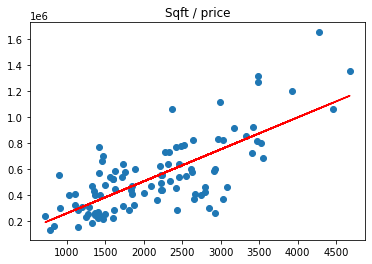

In [69]:
plt.scatter(df['sqft_living'], df["price"])
z = np.polyfit(df['sqft_living'], df["price"], 1)
p = np.poly1d(z)
print(f"Linear function: {p}")
trend_h = p(df['sqft_living'])
plt.plot(df['sqft_living'],trend_h, "r-")
plt.title("Sqft / price")
plt.show()

In [70]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living']}
model_1_prior = CmdStanModel(stan_file='stan_1_ppc.stan')
model_1_prior_simulated = model_1_prior.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [71]:
model_1_prior_simulated.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.0,NaN,0.0,0.00,0.0,0.0,NaN,NaN,NaN
alpha,44000.0,77.000,2500.0,40000.00,44000.0,48000.0,1100.0,14000.0,1.0
beta,280.0,4.500,150.0,12.00,280.0,530.0,1200.0,15000.0,1.0
sigma,2.0,0.055,1.9,0.12,1.4,5.9,1200.0,15000.0,1.0
price[1],814061.0,12623.000,428896.0,78718.00,823729.0,1520490.0,1154.0,14992.0,1.0
...,...,...,...,...,...,...,...,...,...
price[96],400031.0,5838.000,198338.0,60020.00,405630.0,727602.0,1154.0,14990.0,1.0
price[97],662250.0,10135.000,344357.0,71860.00,671005.0,1229770.0,1154.0,14992.0,1.0
price[98],852703.0,13257.000,450416.0,80461.00,862714.0,1594500.0,1154.0,14992.0,1.0


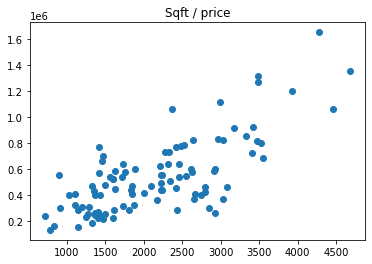

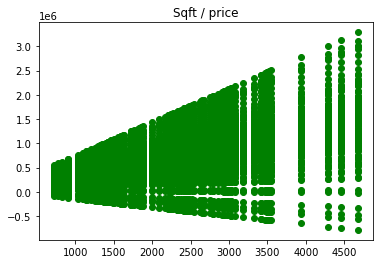

In [72]:
prices_sim=model_1_prior_simulated.stan_variable('price')
plt.scatter(df['sqft_living'], df["price"])
plt.title("Sqft / price")
plt.show()

prices_sim=model_1_prior_simulated.stan_variable('price')

for i in range(0,len(df['sqft_living'])):
    plt.scatter(df['sqft_living'], prices_sim[i], color="g")

plt.title("Sqft / price")
plt.show()

In [73]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living']}
model_2_prior = CmdStanModel(stan_file='stan_2_ppc.stan')
model_2_prior_simulated = model_2_prior.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:compiling stan file /home/nicolas/Projects/DA_project/stan_2_ppc.stan to exe file /home/nicolas/Projects/DA_project/stan_2_ppc
INFO:cmdstanpy:compiled model executable: /home/nicolas/Projects/DA_project/stan_2_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/nicolas/Projects/DA_project/stan_2_ppc.hpp /home/nicolas/Projects/DA_project/stan_2_ppc.stan
Warning in '/home/nicolas/Projects/DA_project/stan_2_ppc.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/nicolas/Projects/DA_project/stan_2_ppc.stan', line 10, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatic


INFO:cmdstanpy:CmdStan done processing.


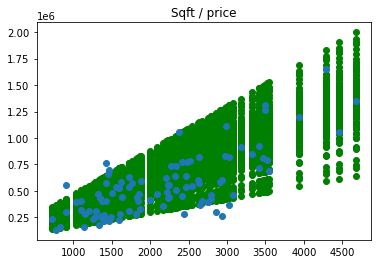

In [74]:
prices_sim=model_2_prior_simulated.stan_variable('price')

for i in range(0,len(df['sqft_living'])):
    plt.scatter(df['sqft_living'], prices_sim[i], color="g")

plt.scatter(df['sqft_living'], df["price"])

plt.title("Sqft / price")
plt.show()

In [75]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living'],
        'price': df['price']}
model_1_posterior = CmdStanModel(stan_file='stan_1_posterior.stan')
model_1_posterior_simulated = model_1_posterior.sample(data=data, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


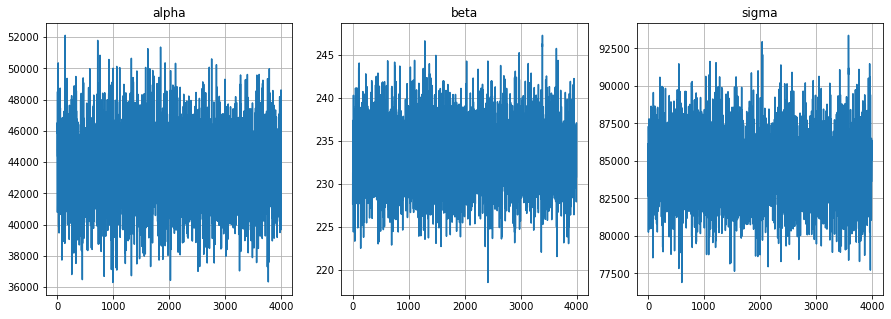

,mean,sd,hdi_3%,hdi_97%
alpha,43606.87,2390.51,38942.20,48040.60
beta,233.41,3.82,226.27,240.58
sigma,84585.56,2226.77,80439.50,88659.50


In [76]:
alpha_sim = model_1_posterior_simulated.stan_variable('alpha')
beta_sim = model_1_posterior_simulated.stan_variable('beta')
sigma_sim = model_1_posterior_simulated.stan_variable('sigma')
price_sim = model_1_posterior_simulated.stan_variable('price_sim')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].plot(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(beta_sim)
axs[1].grid()
axs[1].set_title('beta')
axs[2].plot(sigma_sim)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(model_1_posterior_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

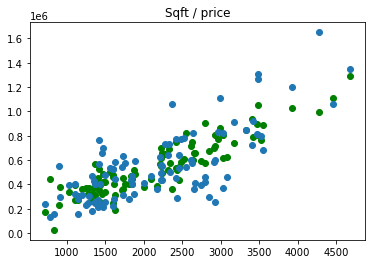

In [78]:
prices_sim=model_1_posterior_simulated.stan_variable('price_sim')

# for i in range(0,len(df['sqft_living'])):
plt.scatter(df['sqft_living'], prices_sim[1], color="g")

plt.scatter(df['sqft_living'], df["price"])

plt.title("Sqft / price")
plt.show()

Linear function:  
1.748e+05 x - 8.289e+05


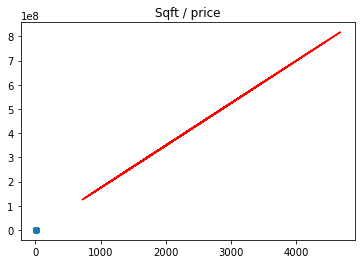

In [55]:
plt.scatter(df['grade'], df["price"])
z = np.polyfit(df['grade'], df["price"], 1)
p = np.poly1d(z)
print(f"Linear function: {p}")
trend_h = p(df['sqft_living'])
plt.plot(df['sqft_living'], trend_h, "r-")
plt.title("Sqft / price")
plt.show()